# Project 3: Credit Defaulting

# Section 1: Importing packages and loading data

## Section 1.1: Package imports

In [3]:
import numpy as np
import pandas as pd
seed = 69 # Set the random seed for the entire document

# Linear Models, their CV and Statsmods
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

# Classifier Metrics 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score

# Pre-processing packages
from sklearn.preprocessing import StandardScaler

# CV, Gridsearch, train_test_split, model selection packages
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

import time
import pickle

# Graph-Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('ggplot')  # nice plots
# sns.set_style('white')
# sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})  # So that your grids have no axis

%matplotlib inline

## Load Datasets

In [4]:
df = pd.read_csv('./dataset/adult_data.csv',index_col = 0)#adult_data_RenameCol_MinMax_LE

In [5]:
df.info()  # we see that we have 30,000 observations and no null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   workclass       32560 non-null  object
 2   fnlwgt          32560 non-null  int64 
 3   education       32560 non-null  object
 4   education-num   32560 non-null  int64 
 5   marital-status  32560 non-null  object
 6   occupation      32560 non-null  object
 7   relationship    32560 non-null  object
 8   race            32560 non-null  object
 9   sex             32560 non-null  object
 10  capital-gain    32560 non-null  int64 
 11  capital-loss    32560 non-null  int64 
 12  hours-per-week  32560 non-null  int64 
 13  native-country  32560 non-null  object
 14  class           32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


In [6]:
# We inspect the data as a whole|
df1 = df.copy()
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32560.0,38.581634,13.640642,17.0,28.0,37.0,48.0,90.0
fnlwgt,32560.0,189781.814373,105549.764924,12285.0,117831.5,178363.0,237054.5,1484705.0
education-num,32560.0,10.080590,2.572709,1.0,9.0,10.0,12.0,16.0
capital-gain,32560.0,1077.615172,7385.402999,0.0,0.0,0.0,0.0,99999.0
capital-loss,32560.0,87.306511,402.966116,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32560.0,40.437469,12.347618,1.0,40.0,40.0,45.0,99.0


## Data Cleaning

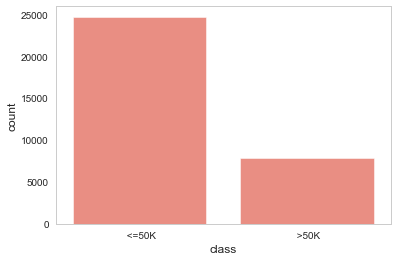

In [7]:
# Being fancy again
fig, ax = plt.subplots()
sns.countplot(data=df,x='class', order = df['class'].value_counts().index, color='salmon');
# df['EDUCATION'].value_counts().plot(kind='bar', );

In [9]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


# Education Count

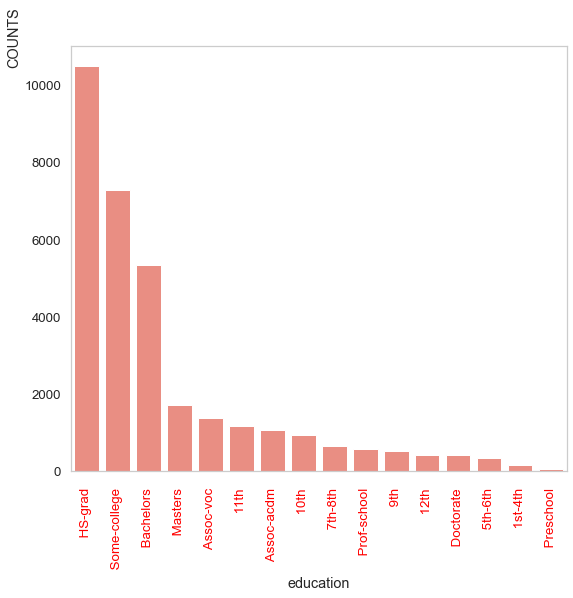

In [43]:
# Fancy smanshi
def get_plot_count(df_col):#eg df['education']
    fig, ax = plt.subplots()
    sns.countplot(data=df, x='education', order = df_col.value_counts().index, color='salmon')
    ax.set_ylabel('COUNTS', rotation=90, labelpad=40)
    ax.yaxis.set_label_coords(-0.1,1.02)
    # plt.xticks(df, x='education', color='orange', rotation=90, fontweight='bold', fontsize='15')
    fig.set_size_inches(8, 8)
    plt.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

    plt.tight_layout()
    plt.show()
get_plot_count(df['education'])

# Section 2: Data Exploration

## Section 2.1: Mapping the Target

In [10]:
def get_class_binary(x):
    if x == " <=50K":
        x = 0
    if x == ' >50K':
        x = 1
    return x
df['class'] = df['class'].apply(lambda x: get_class_binary(x))

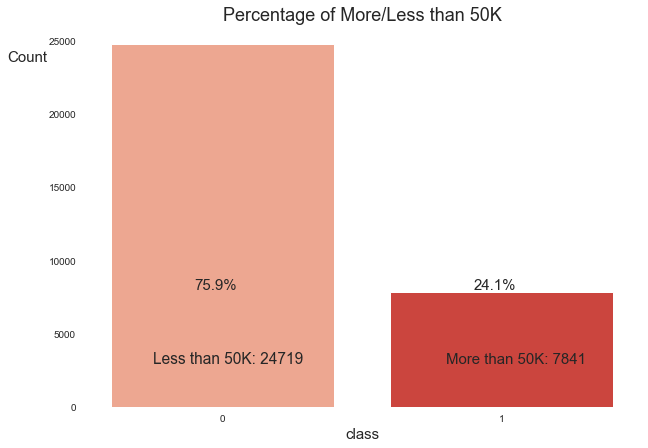

In [11]:
# Frequency of the defaults
default = df['class'].sum() # adds up all the default cases in the df
no_default = len(df['class']) - int(default)  # entire dataset - default cases

# Percentage of the defaults
default_perc = round(default/len(df['class']) * 100, 1)
no_default_perc = round(no_default/len(df['class']) * 100, 1)

# Plotting Target
fig, ax = plt.subplots(figsize=(10,7))  # Sets size of graph
sns.set_context('notebook', font_scale=1.2)  # Affects things like size of label, lines and other elements of the plot.

sns.countplot('class',data=df, palette="Reds")   
plt.annotate('Less than 50K: {}'.format(no_default), 
             xy=(-0.25, 3000), # xy = (x dist from 0, y dist from 0)
            size=15.5)

plt.annotate('More than 50K: {}'.format(default), 
             xy=(0.8, 3000), # xy = (x dist from 0, y dist from 0)
            size=15)
plt.annotate('{}%'.format(no_default_perc), xy=(-0.1, 8000),size=15)
plt.annotate('{}%'.format(default_perc), xy=(0.9, 8000),size=15)
plt.title('Percentage of More/Less than 50K', size=18)
plt.xlabel("class",size=15)
plt.ylabel('Count', rotation=0, 
           labelpad=40, # Adjusts distance of the title from the graph
           size=15)
ax.yaxis.set_label_coords(-0.1,.9)

plt.box(False)        # Removes the bounding area
plt.savefig('target_skew.png', transparent = True)

## Frequency of explanatory variables by Class 0 or 1; <=50K / >50K

In [14]:
# df_categorical 
columns_that_are_numerical = df.dtypes == object
columns_that_are_numerical = df.columns[columns_that_are_numerical].tolist()
print('columns_that_are_numerical:',columns_that_are_numerical)
df_categorical = df[columns_that_are_numerical]
df_categorical.head()

columns_that_are_numerical: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States


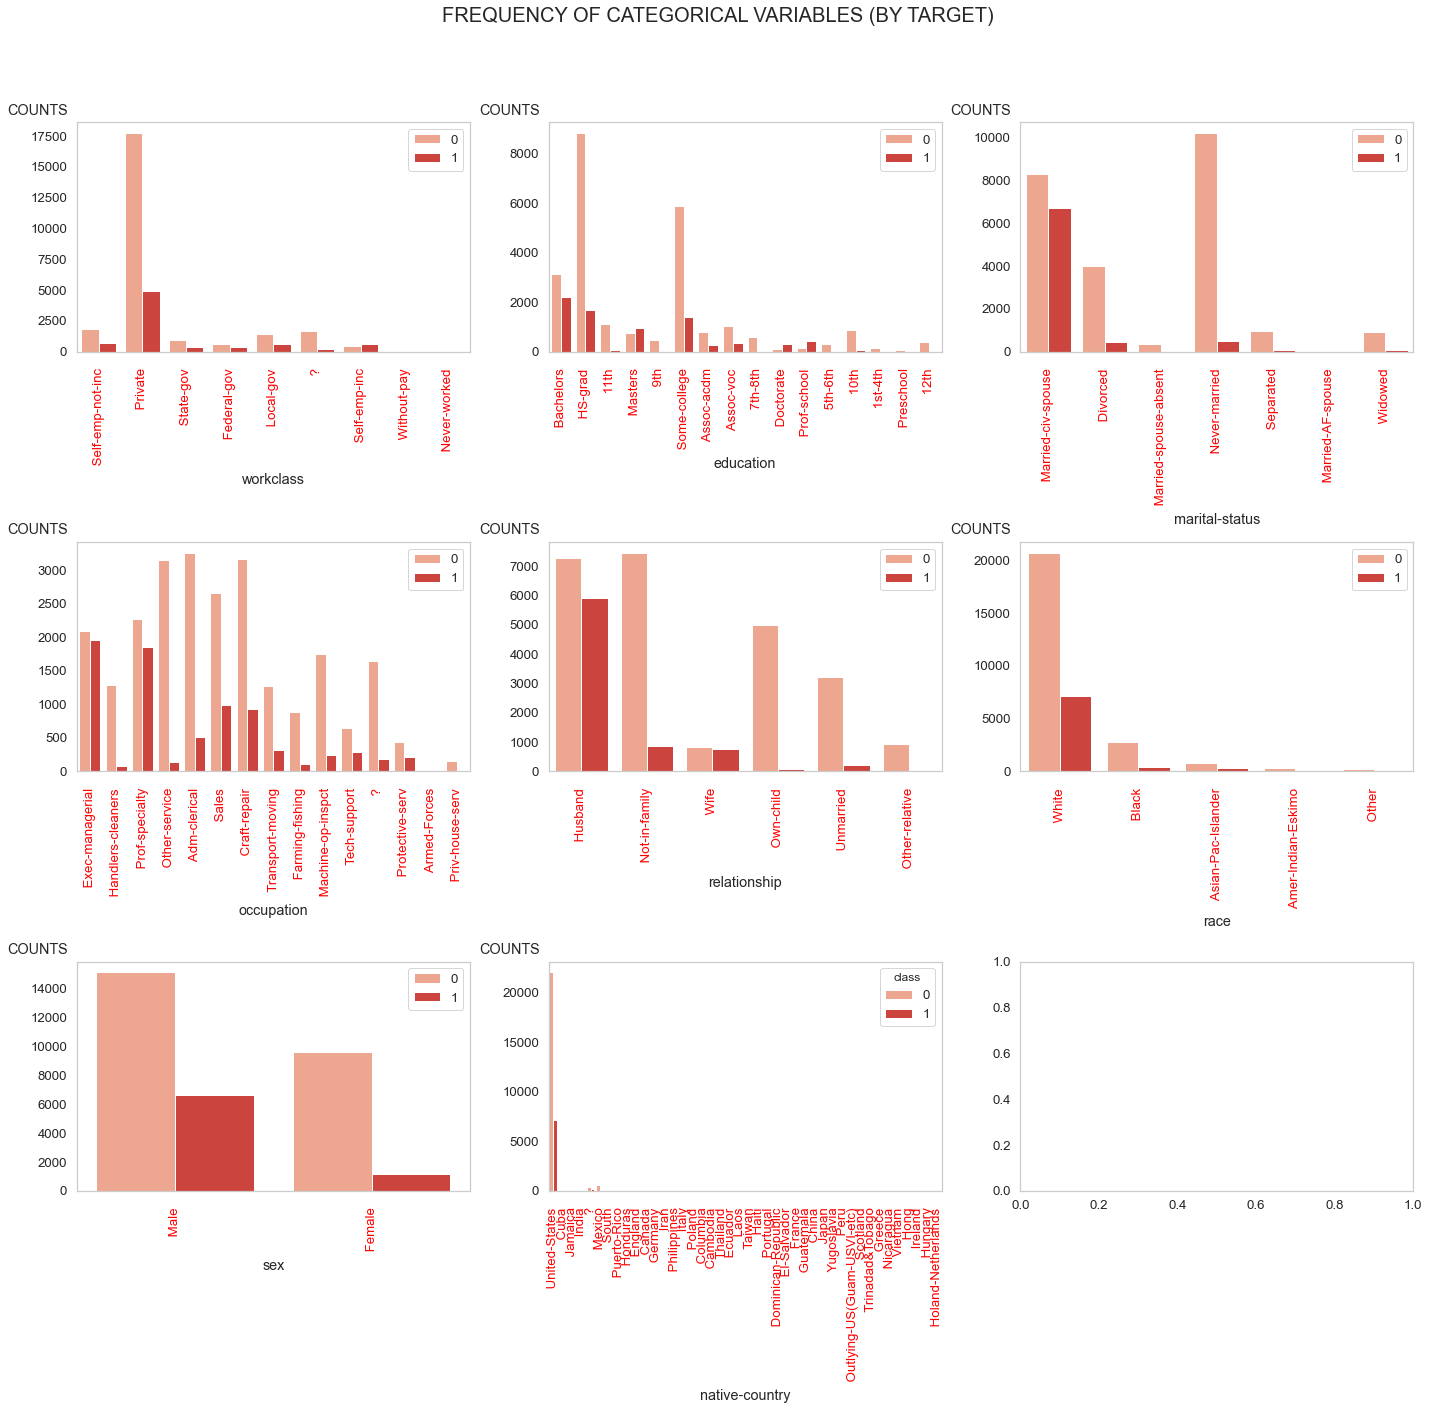

In [17]:
f, axes = plt.subplots(3, 3, figsize=(20,20), facecolor='white')
f.suptitle("FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)",size=20)

# Creating plots of each categorical variable to target 
ax1 = sns.countplot(x=columns_that_are_numerical[0], hue='class',data=df, palette='Reds', ax=axes[0,0])
ax2 = sns.countplot(x=columns_that_are_numerical[1], hue='class',data=df, palette='Reds', ax=axes[0,1])
ax3 = sns.countplot(x=columns_that_are_numerical[2], hue='class',data=df, palette='Reds', ax=axes[0,2])
ax4 = sns.countplot(x=columns_that_are_numerical[3], hue='class',data=df, palette='Reds', ax=axes[1,0])
ax5 = sns.countplot(x=columns_that_are_numerical[4], hue='class',data=df, palette='Reds', ax=axes[1,1])
ax6 = sns.countplot(x=columns_that_are_numerical[5], hue='class',data=df, palette='Reds', ax=axes[1,2])
ax7 = sns.countplot(x=columns_that_are_numerical[6], hue='class',data=df, palette='Reds', ax=axes[2,0])
ax8 = sns.countplot(x=columns_that_are_numerical[7], hue='class',data=df, palette='Reds', ax=axes[2,1])
# ax9 = sns.countplot(x='PAY_6', hue = 'DEFAULT', data=df_categorical, palette='Reds', ax=axes[2,2])

# Setting legends to upper right
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax3.legend(loc="upper right")
ax4.legend(loc="upper right")
ax5.legend(loc="upper right")
ax6.legend(loc="upper right")
ax7.legend(loc="upper right")
# ax8.legend(loc="upper right")
# ax9.legend(loc="upper right")

# Changing ylabels to horizontal and changing their positions
ax1.set_ylabel('COUNTS', rotation=0, labelpad=40)  # Labelpad adjusts distance of the title from the graph
ax1.yaxis.set_label_coords(-0.1,1.02)              # (x, y)
ax1.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

ax2.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax2.yaxis.set_label_coords(-0.1,1.02)
ax2.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

ax3.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax3.yaxis.set_label_coords(-0.1,1.02)
ax3.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

ax4.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax4.yaxis.set_label_coords(-0.1,1.02)
ax4.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

ax5.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax5.yaxis.set_label_coords(-0.1,1.02)
ax5.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

ax6.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax6.yaxis.set_label_coords(-0.1,1.02)
ax6.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

ax7.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax7.yaxis.set_label_coords(-0.1,1.02)
ax7.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

ax8.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax8.yaxis.set_label_coords(-0.1,1.02)
ax8.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

# Shifting the Super Title higher
f.tight_layout()  # Prevents graphs from overlapping with each other
f.subplots_adjust(top=0.9);

In [52]:
df['age']

0        50
1        38
2        53
3        28
4        37
         ..
32555    27
32556    40
32557    58
32558    22
32559    52
Name: age, Length: 32560, dtype: int64

# Bank By Age

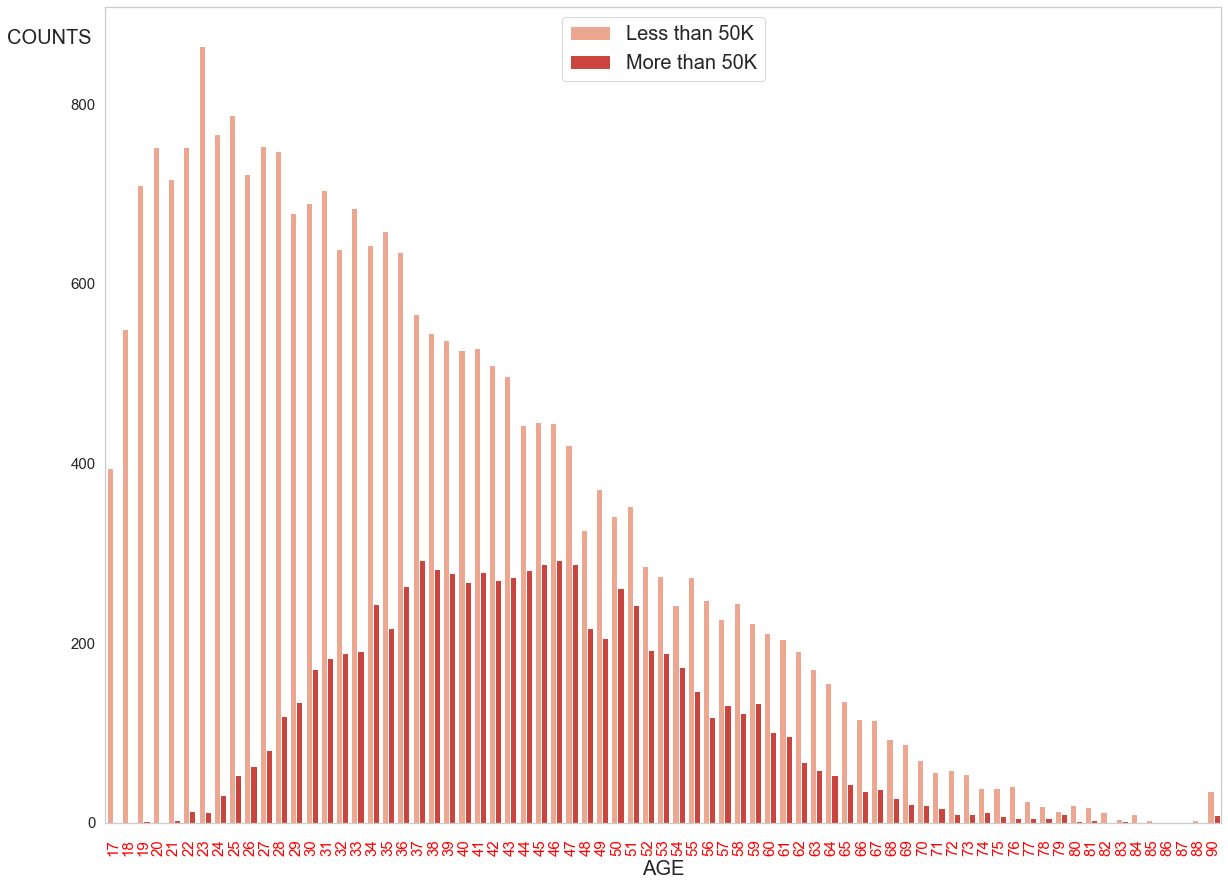

In [107]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15

axz = sns.countplot(x='age', hue='class', data=df, palette='Reds')

axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('AGE', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(['Less than 50K', 'More than 50K'],loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)


# Bank By workclass

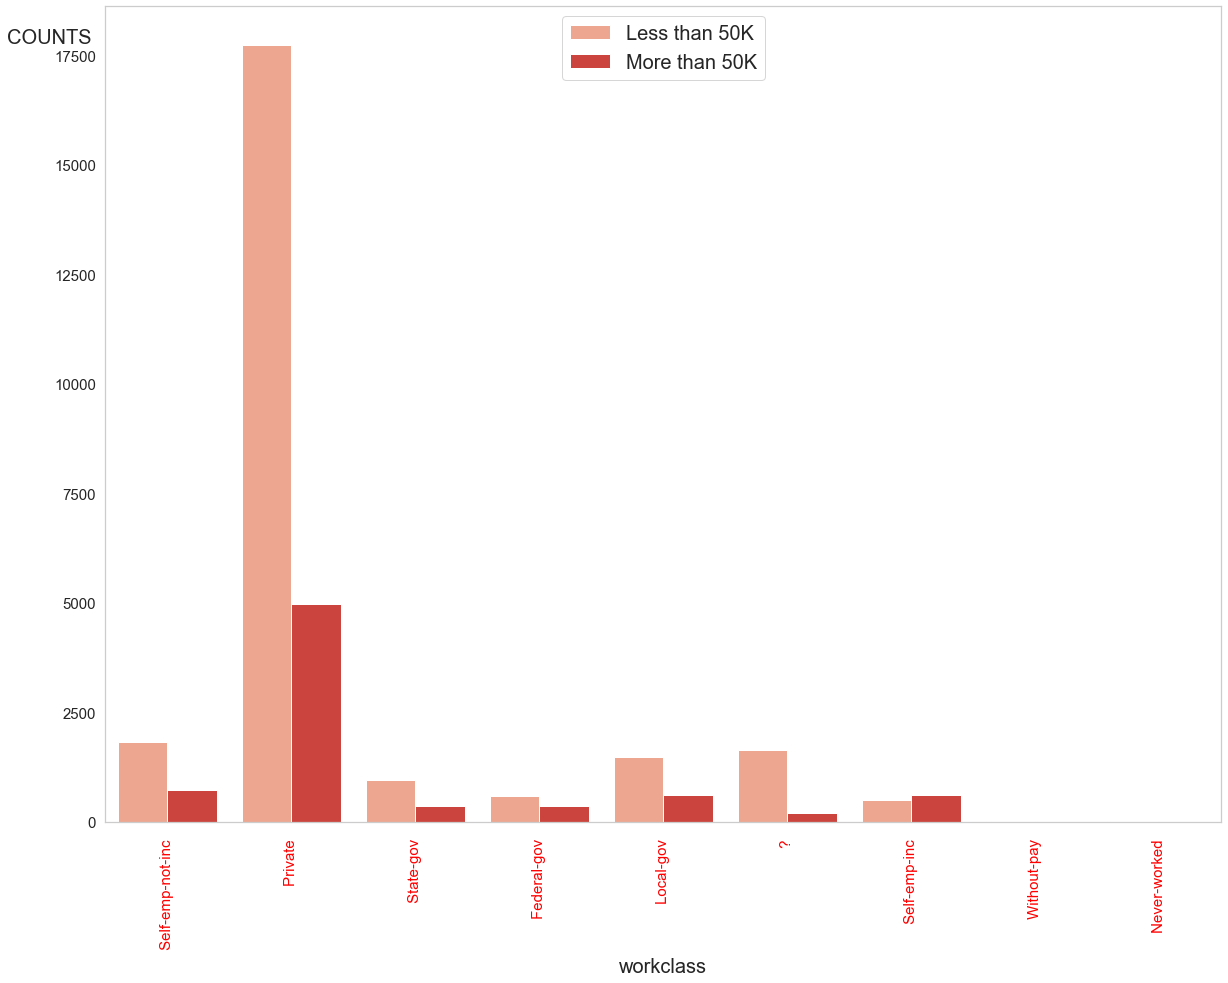

In [109]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15

axz = sns.countplot(x='workclass', hue='class', data=df, palette='Reds')

axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('workclass', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(['Less than 50K', 'More than 50K'],loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)


# Bank By education

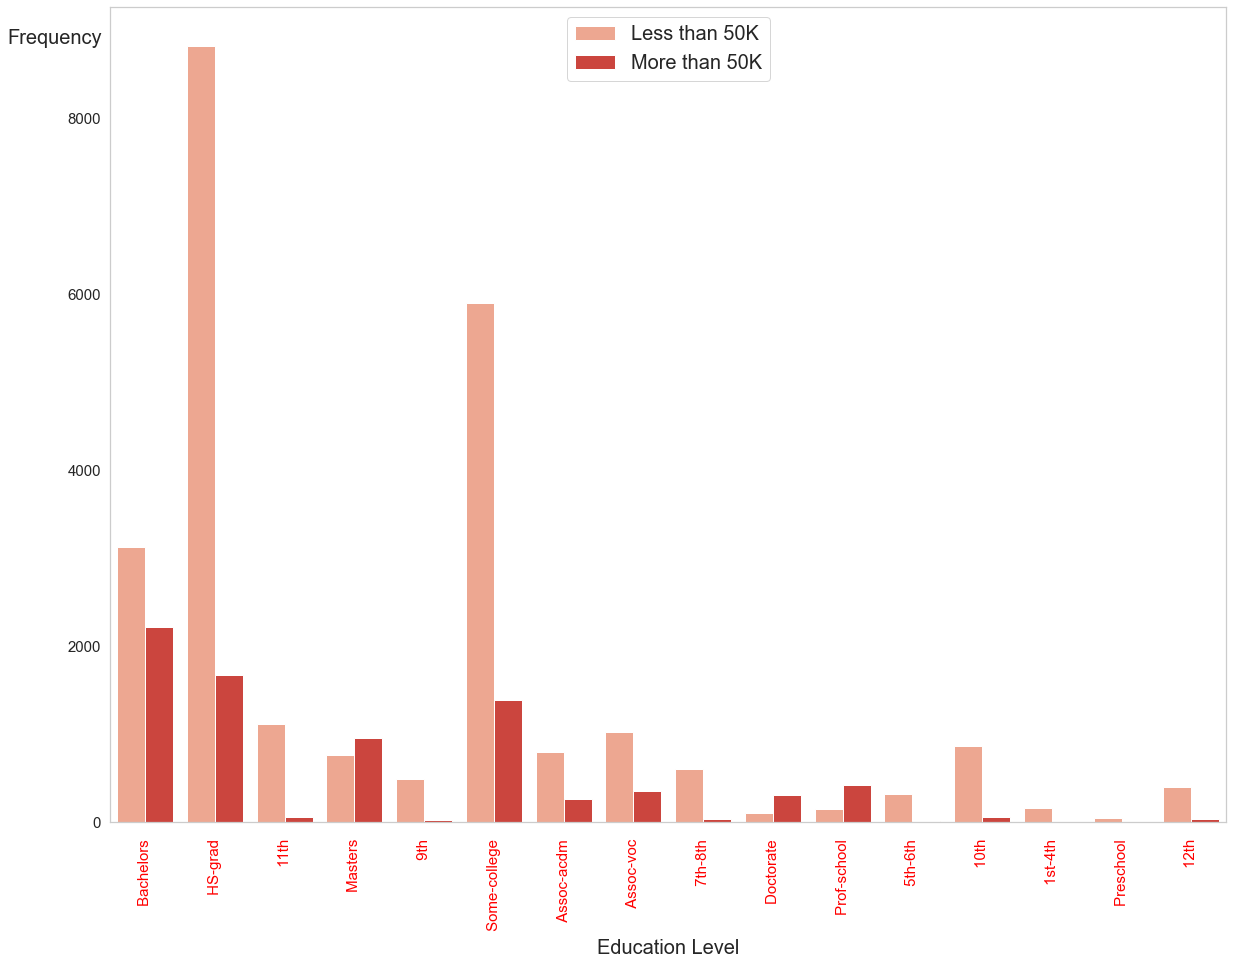

In [105]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15
axz = sns.countplot(x='education', hue='class', data=df, palette='Reds')

axz.set_ylabel('Frequency', rotation=0, labelpad=40,size=20)
axz.set_xlabel('Education Level', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(['Less than 50K','More than 50K'],loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

# Bank By education

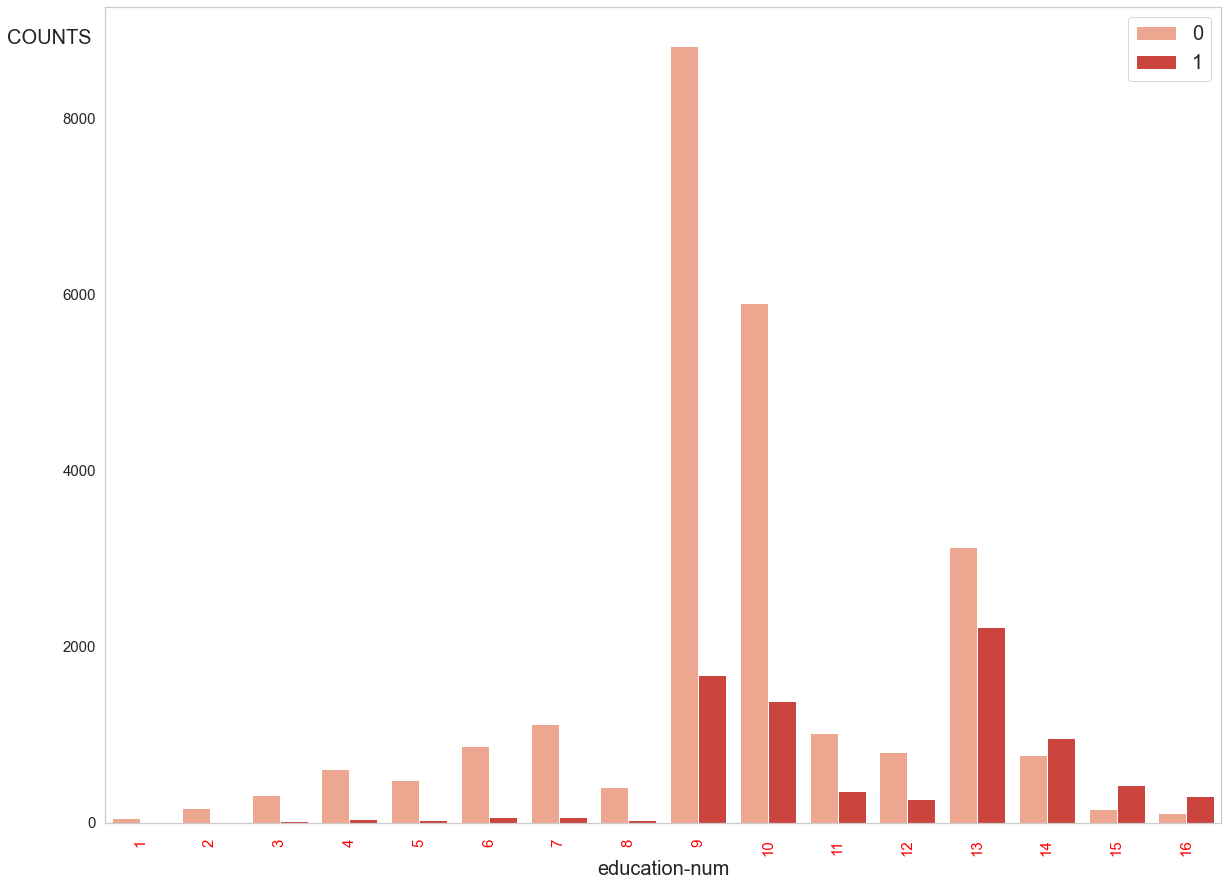

In [100]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15

axz = sns.countplot(x='education-num', hue='class', data=df, palette='Reds')

axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('education-num', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

# Bank By marital-status

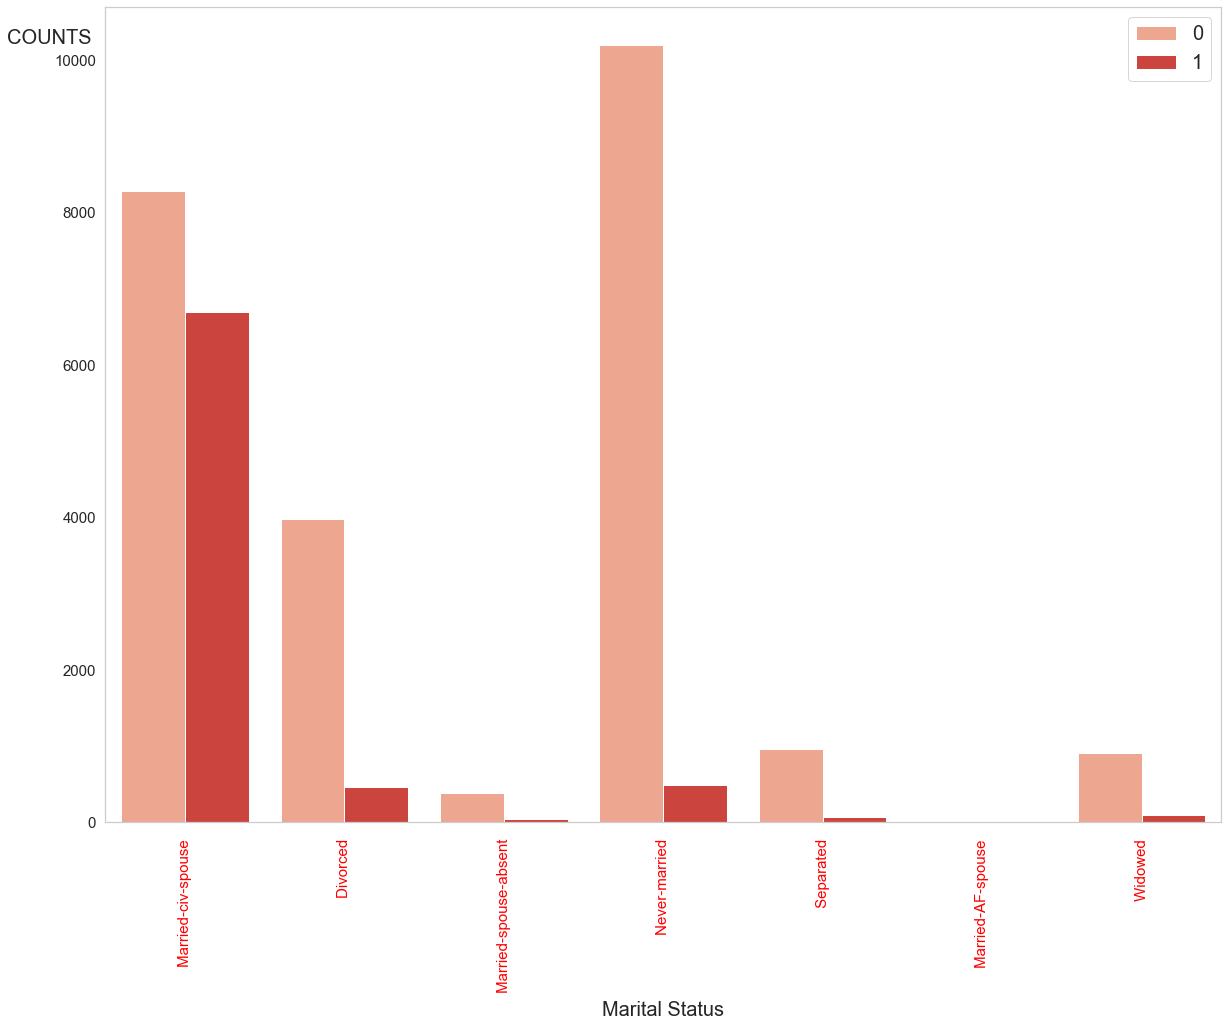

In [18]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15

axz = sns.countplot(x='marital-status', hue='class', data=df, palette='Reds')

axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('Marital Status', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

# Bank By occupation

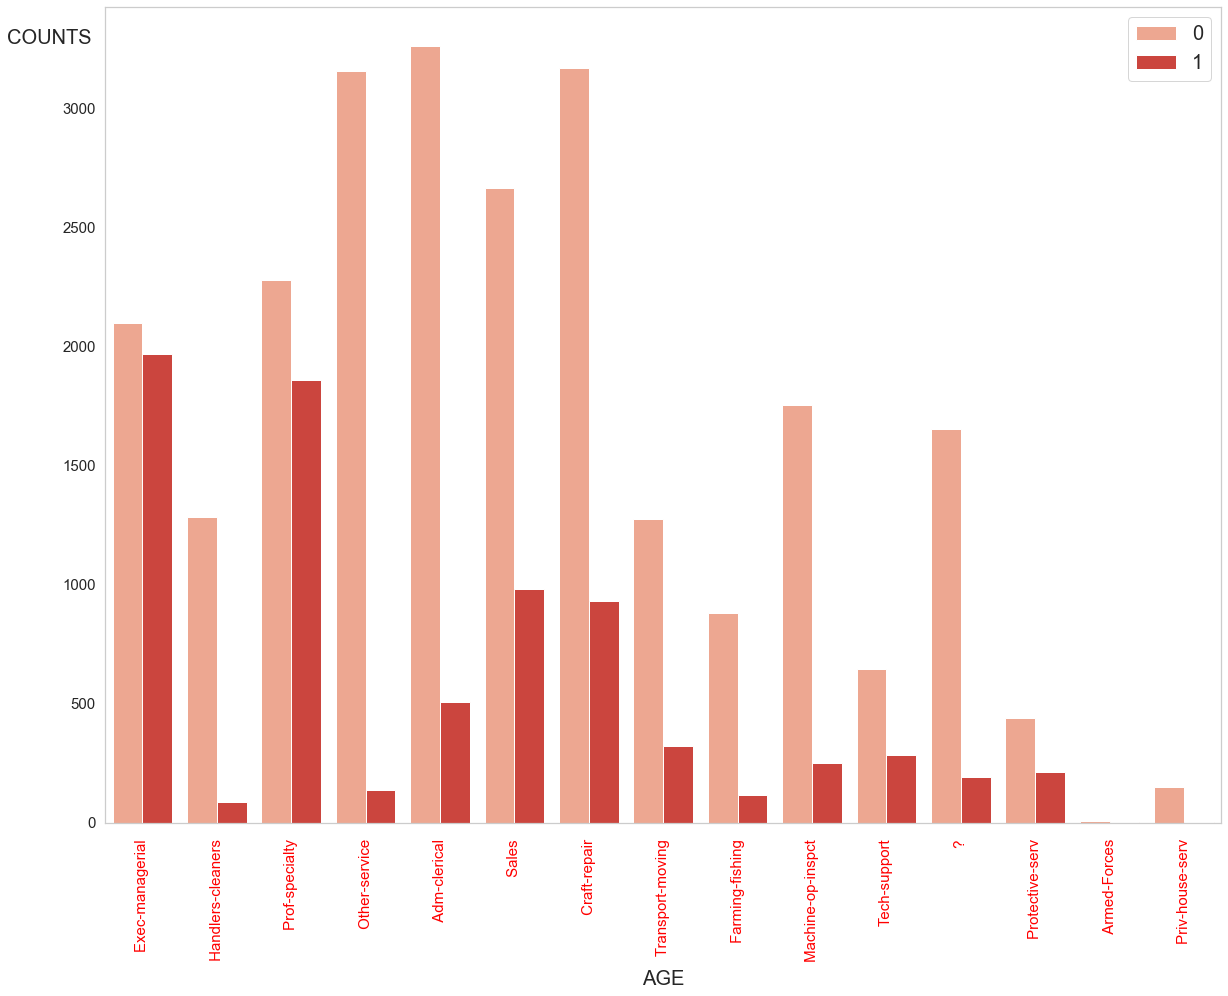

In [89]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15

axz = sns.countplot(x='occupation', hue='class', data=df, palette='Reds')


axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('AGE', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)


# Bank By relationship

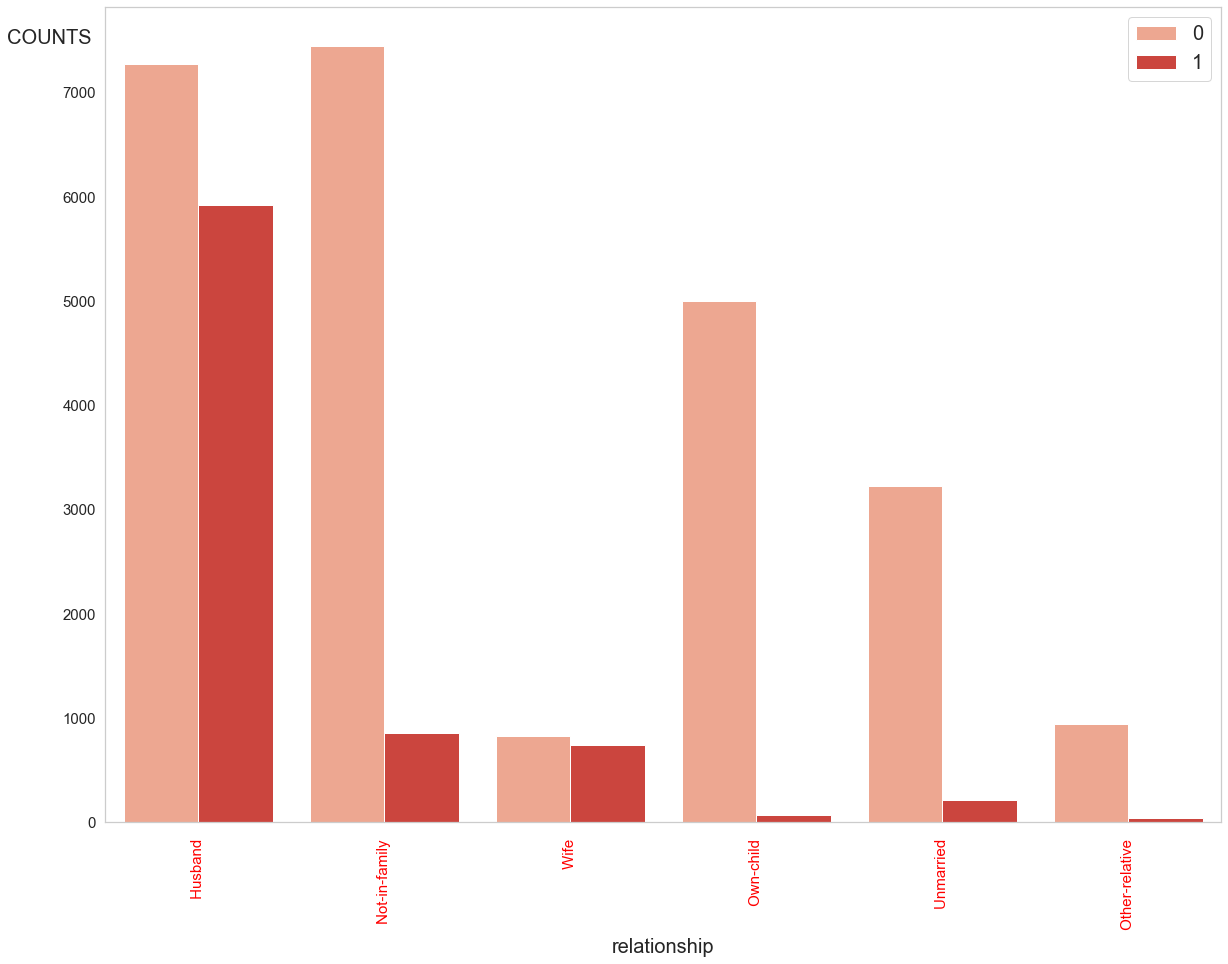

In [91]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15

axz = sns.countplot(x='relationship', hue='class', data=df, palette='Reds')

axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('relationship', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)


# Bank By race

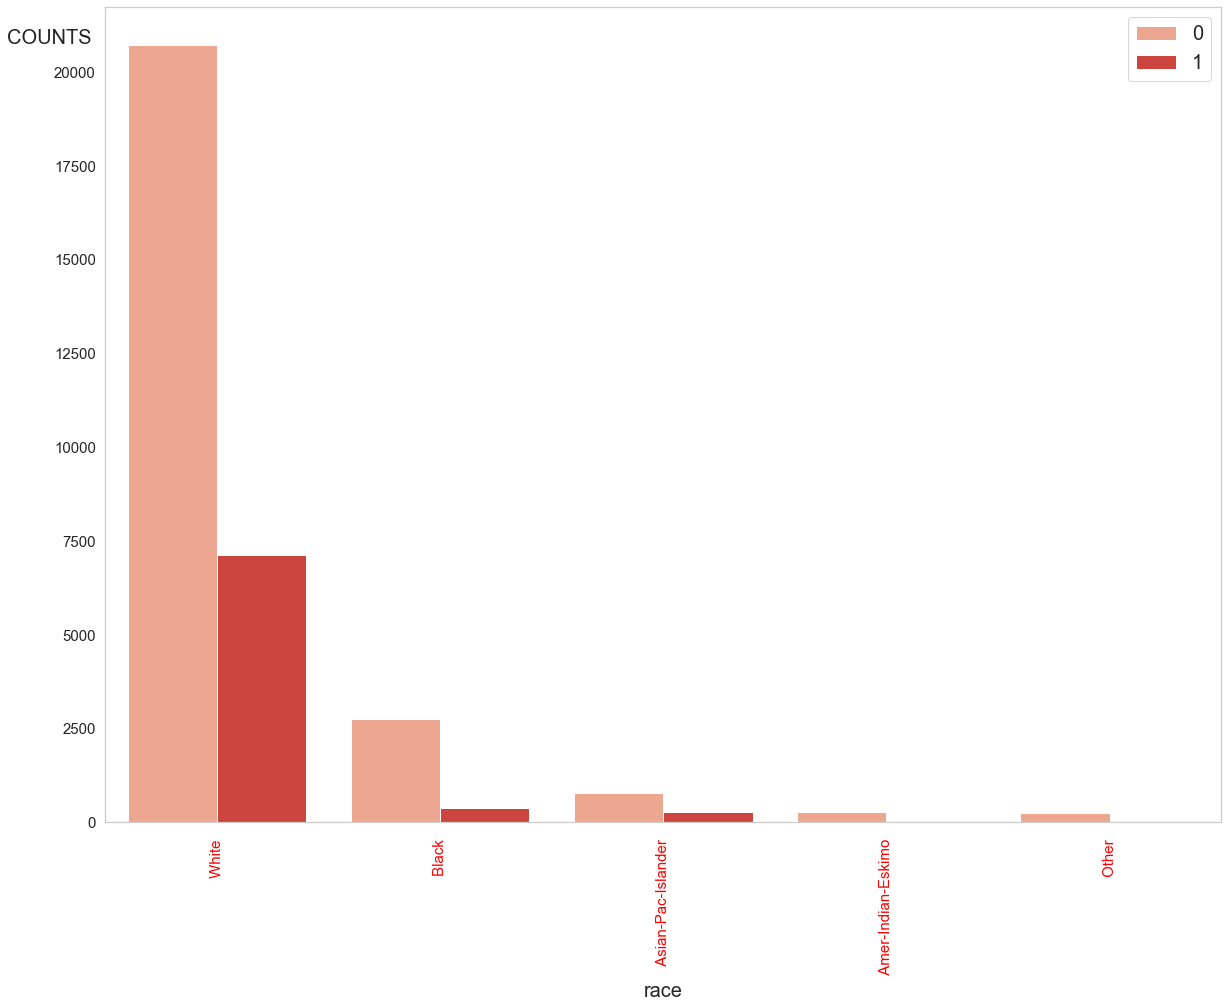

In [92]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15

axz = sns.countplot(x='race', hue='class', data=df, palette='Reds')

axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('race', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

# Bank By sex

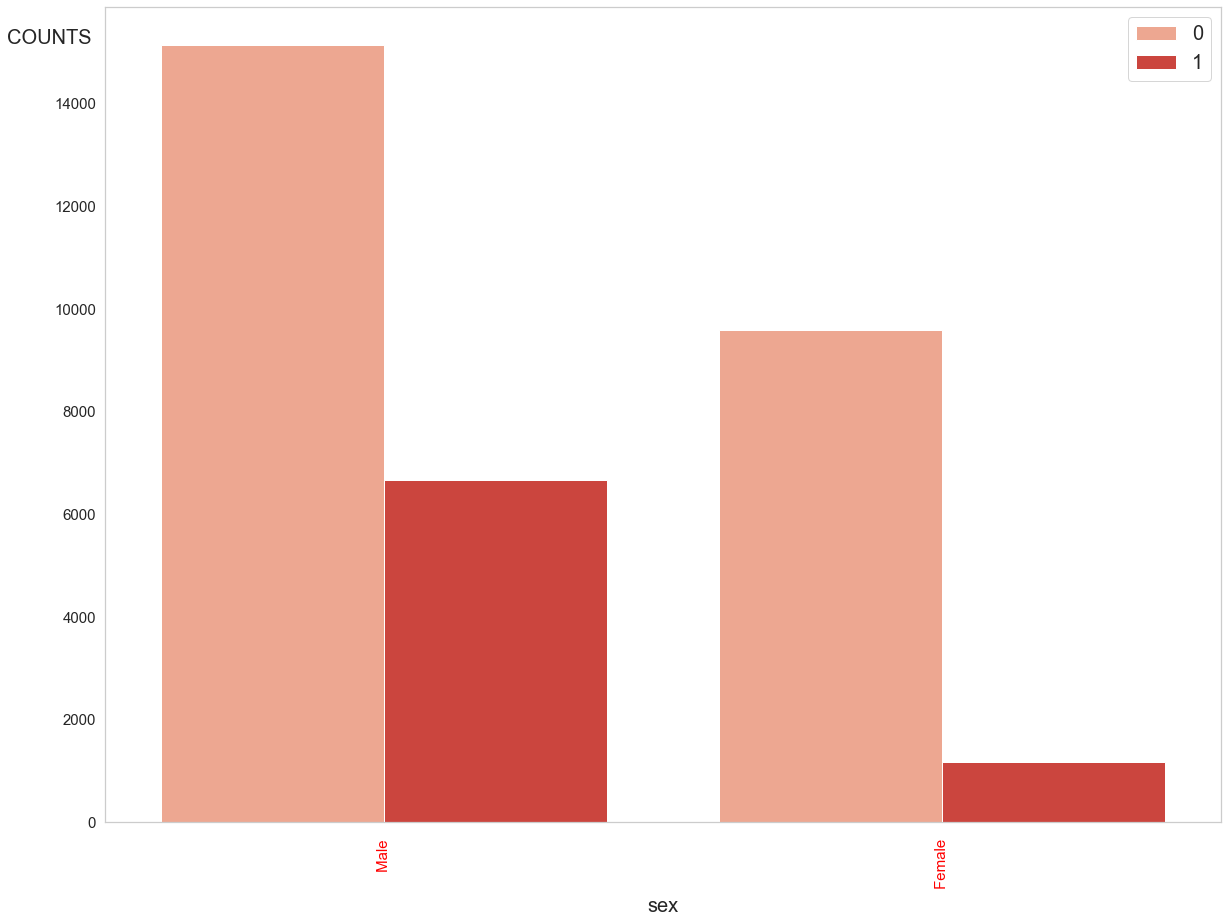

In [93]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15

axz = sns.countplot(x='sex', hue='class', data=df, palette='Reds')

axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('sex', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)


# Bank By native-country

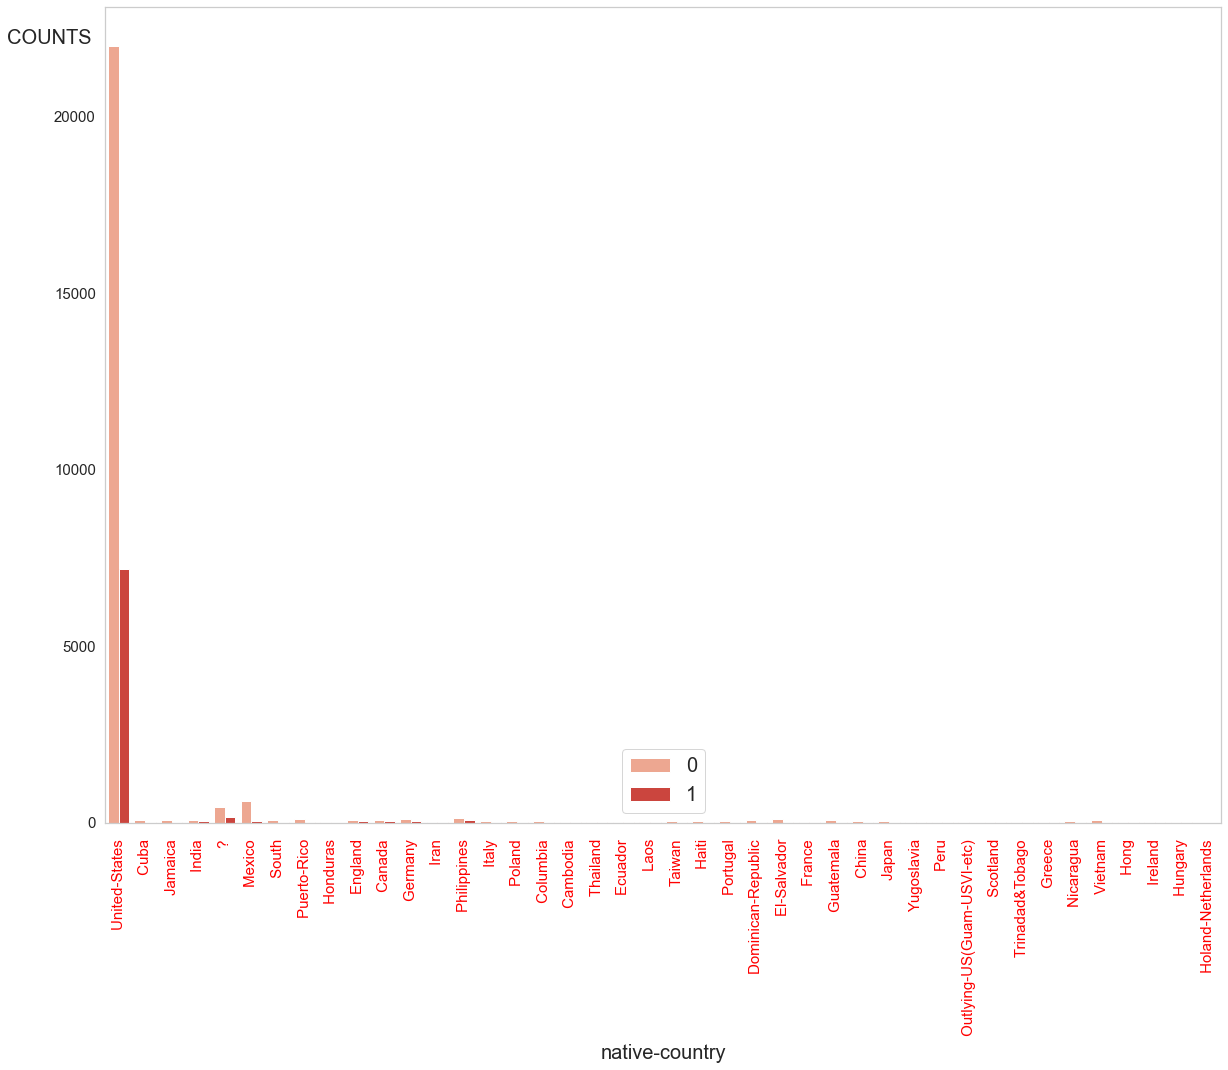

In [98]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15

axz = sns.countplot(x='native-country', hue='class', data=df, palette='Reds')


axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('native-country', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)


# Bank By hours-per-week

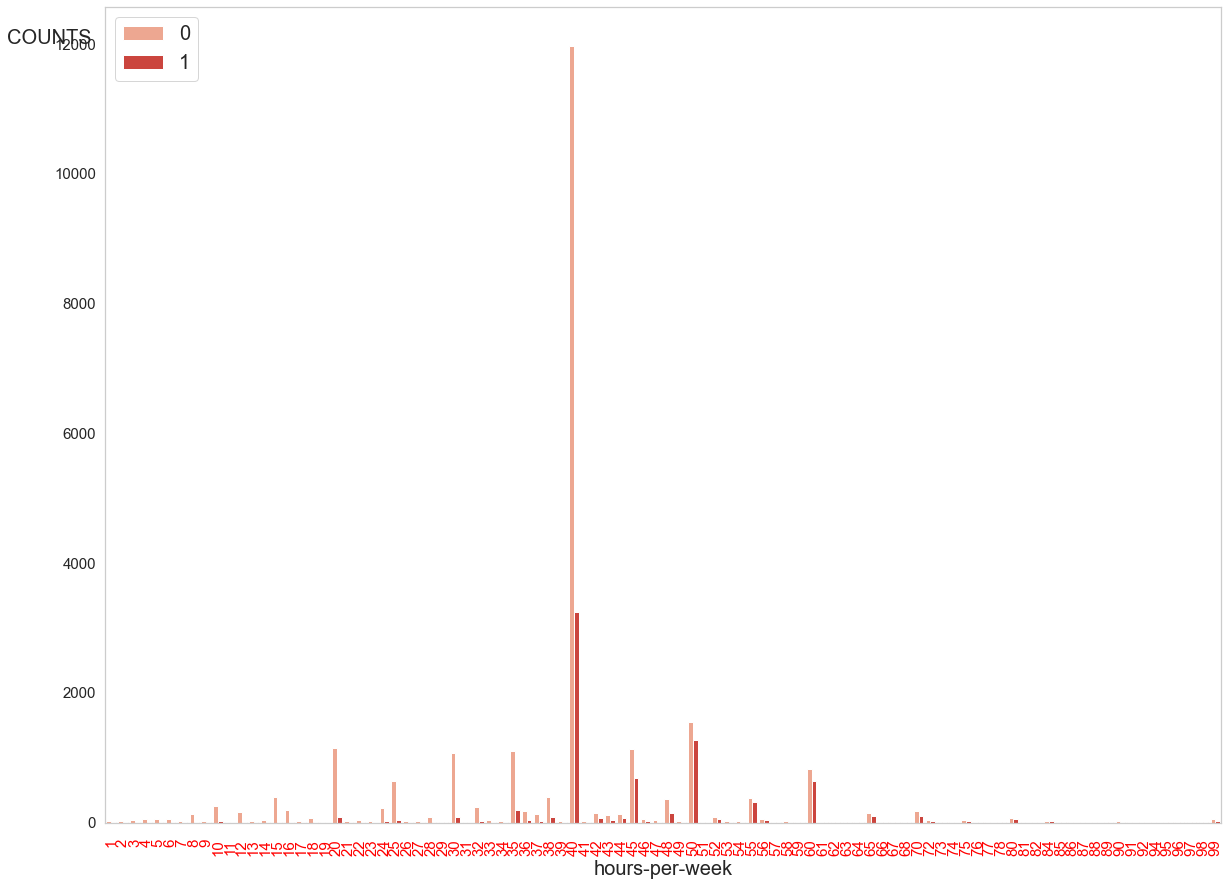

In [94]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))#20,15

axz = sns.countplot(x='hours-per-week', hue='class', data=df, palette='Reds')

axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('hours-per-week', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(loc=0,fontsize=20);

axz.tick_params(labelsize=15,direction='out')  # Changes size of the values on the label
axz.tick_params(axis='x', colors='red', direction='out', length=13, width=3,rotation=90)

c:\users\malco\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


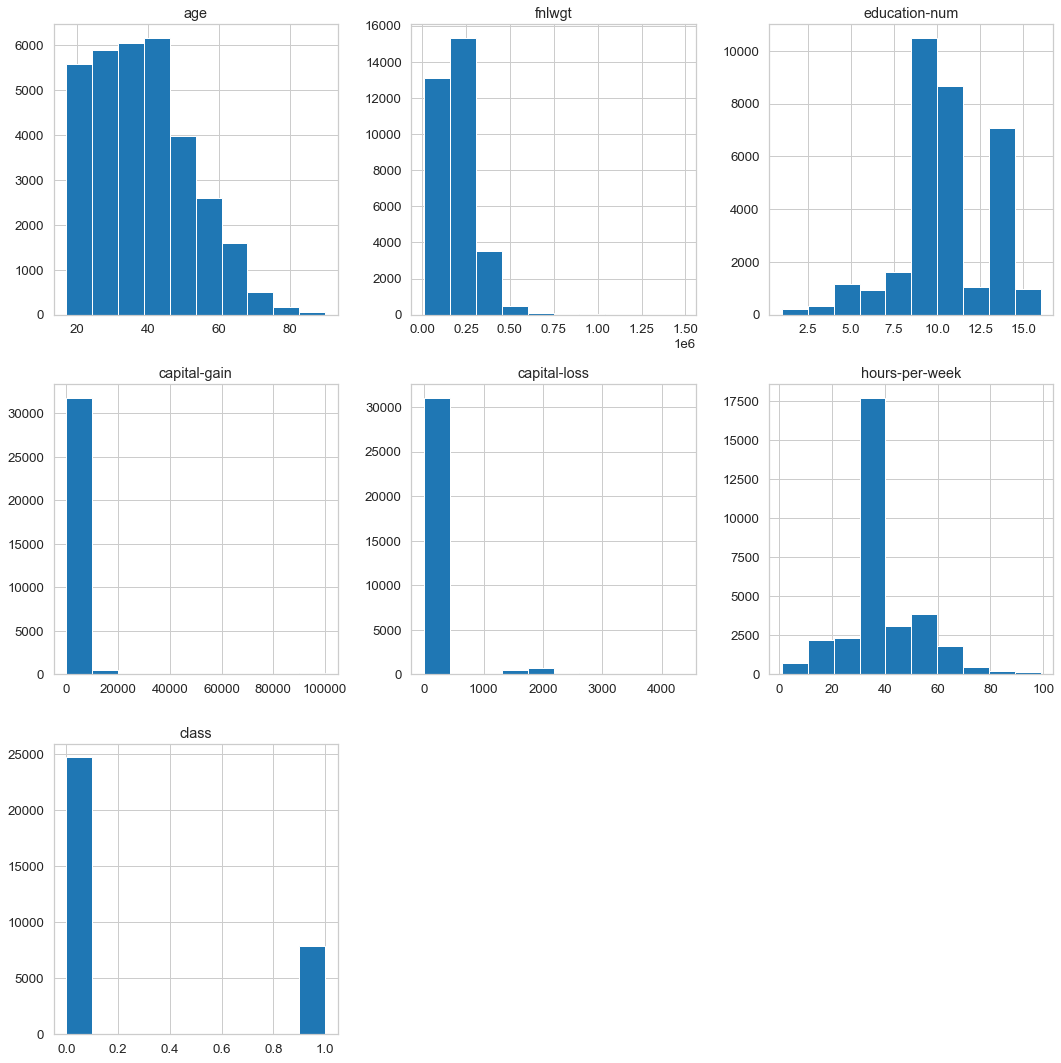

In [54]:
# Freq distribution of all data
fig, ax = plt.subplots(figsize=(15,15))
pd.DataFrame.hist(df,ax=ax)
plt.tight_layout();

c:\users\malco\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  del sys.path[0]


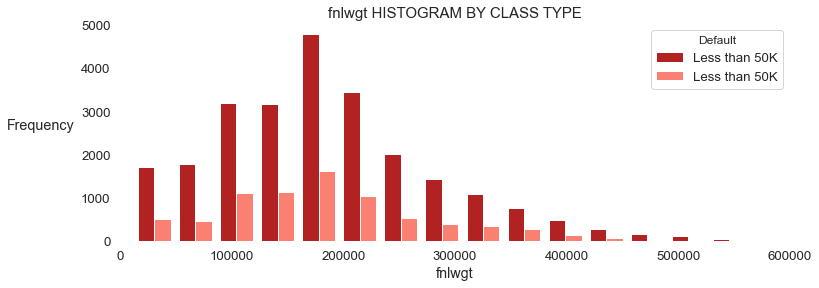

In [21]:
# Can we infer more? what about the columns for lIMIT_BALANCE?
# from collections import Counter
x1 = list(df[df['class'] == 0]['fnlwgt'])
x2 = list(df[df['class'] == 1]['fnlwgt'])
fig2, ax_lim_bal = plt.subplots(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 40, density =False, color=['firebrick', 'salmon'])
plt.xlim([0,600000])
plt.legend(['Less than 50K', 'Less than 50K'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('fnlwgt')
plt.ylabel('Frequency', rotation=0,labelpad=40)
plt.title('fnlwgt HISTOGRAM BY CLASS TYPE', SIZE=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

c:\users\malco\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':


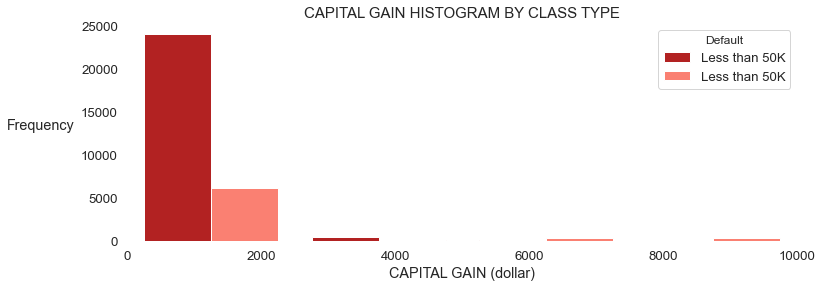

In [23]:
# from collections import Counter
x1 = list(df[df['class'] == 0]['capital-gain'])
x2 = list(df[df['class'] == 1]['capital-gain'])
fig2, ax_lim_bal = plt.subplots(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 40, density =False, color=['firebrick', 'salmon'])
plt.xlim([0,10000])
plt.legend(['Less than 50K', 'Less than 50K'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('CAPITAL GAIN (dollar)')
plt.ylabel('Frequency', rotation=0,labelpad=40)
plt.title('CAPITAL GAIN HISTOGRAM BY CLASS TYPE', SIZE=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

c:\users\malco\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':


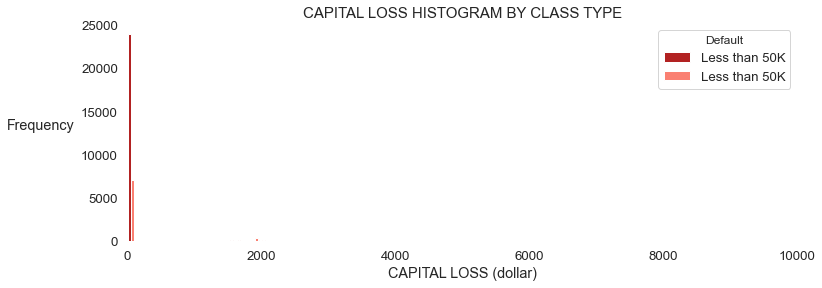

In [24]:
# from collections import Counter
x1 = list(df[df['class'] == 0]['capital-loss'])
x2 = list(df[df['class'] == 1]['capital-loss'])
fig2, ax_lim_bal = plt.subplots(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 40, density =False, color=['firebrick', 'salmon'])
plt.xlim([0,10000])
plt.legend(['Less than 50K', 'Less than 50K'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('CAPITAL LOSS (dollar)')
plt.ylabel('Frequency', rotation=0,labelpad=40)
plt.title('CAPITAL LOSS HISTOGRAM BY CLASS TYPE', SIZE=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

# Section 3: Feature Selection 

## Section 3.1: Correlation Matrix 

In [25]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'class'],
      dtype='object')

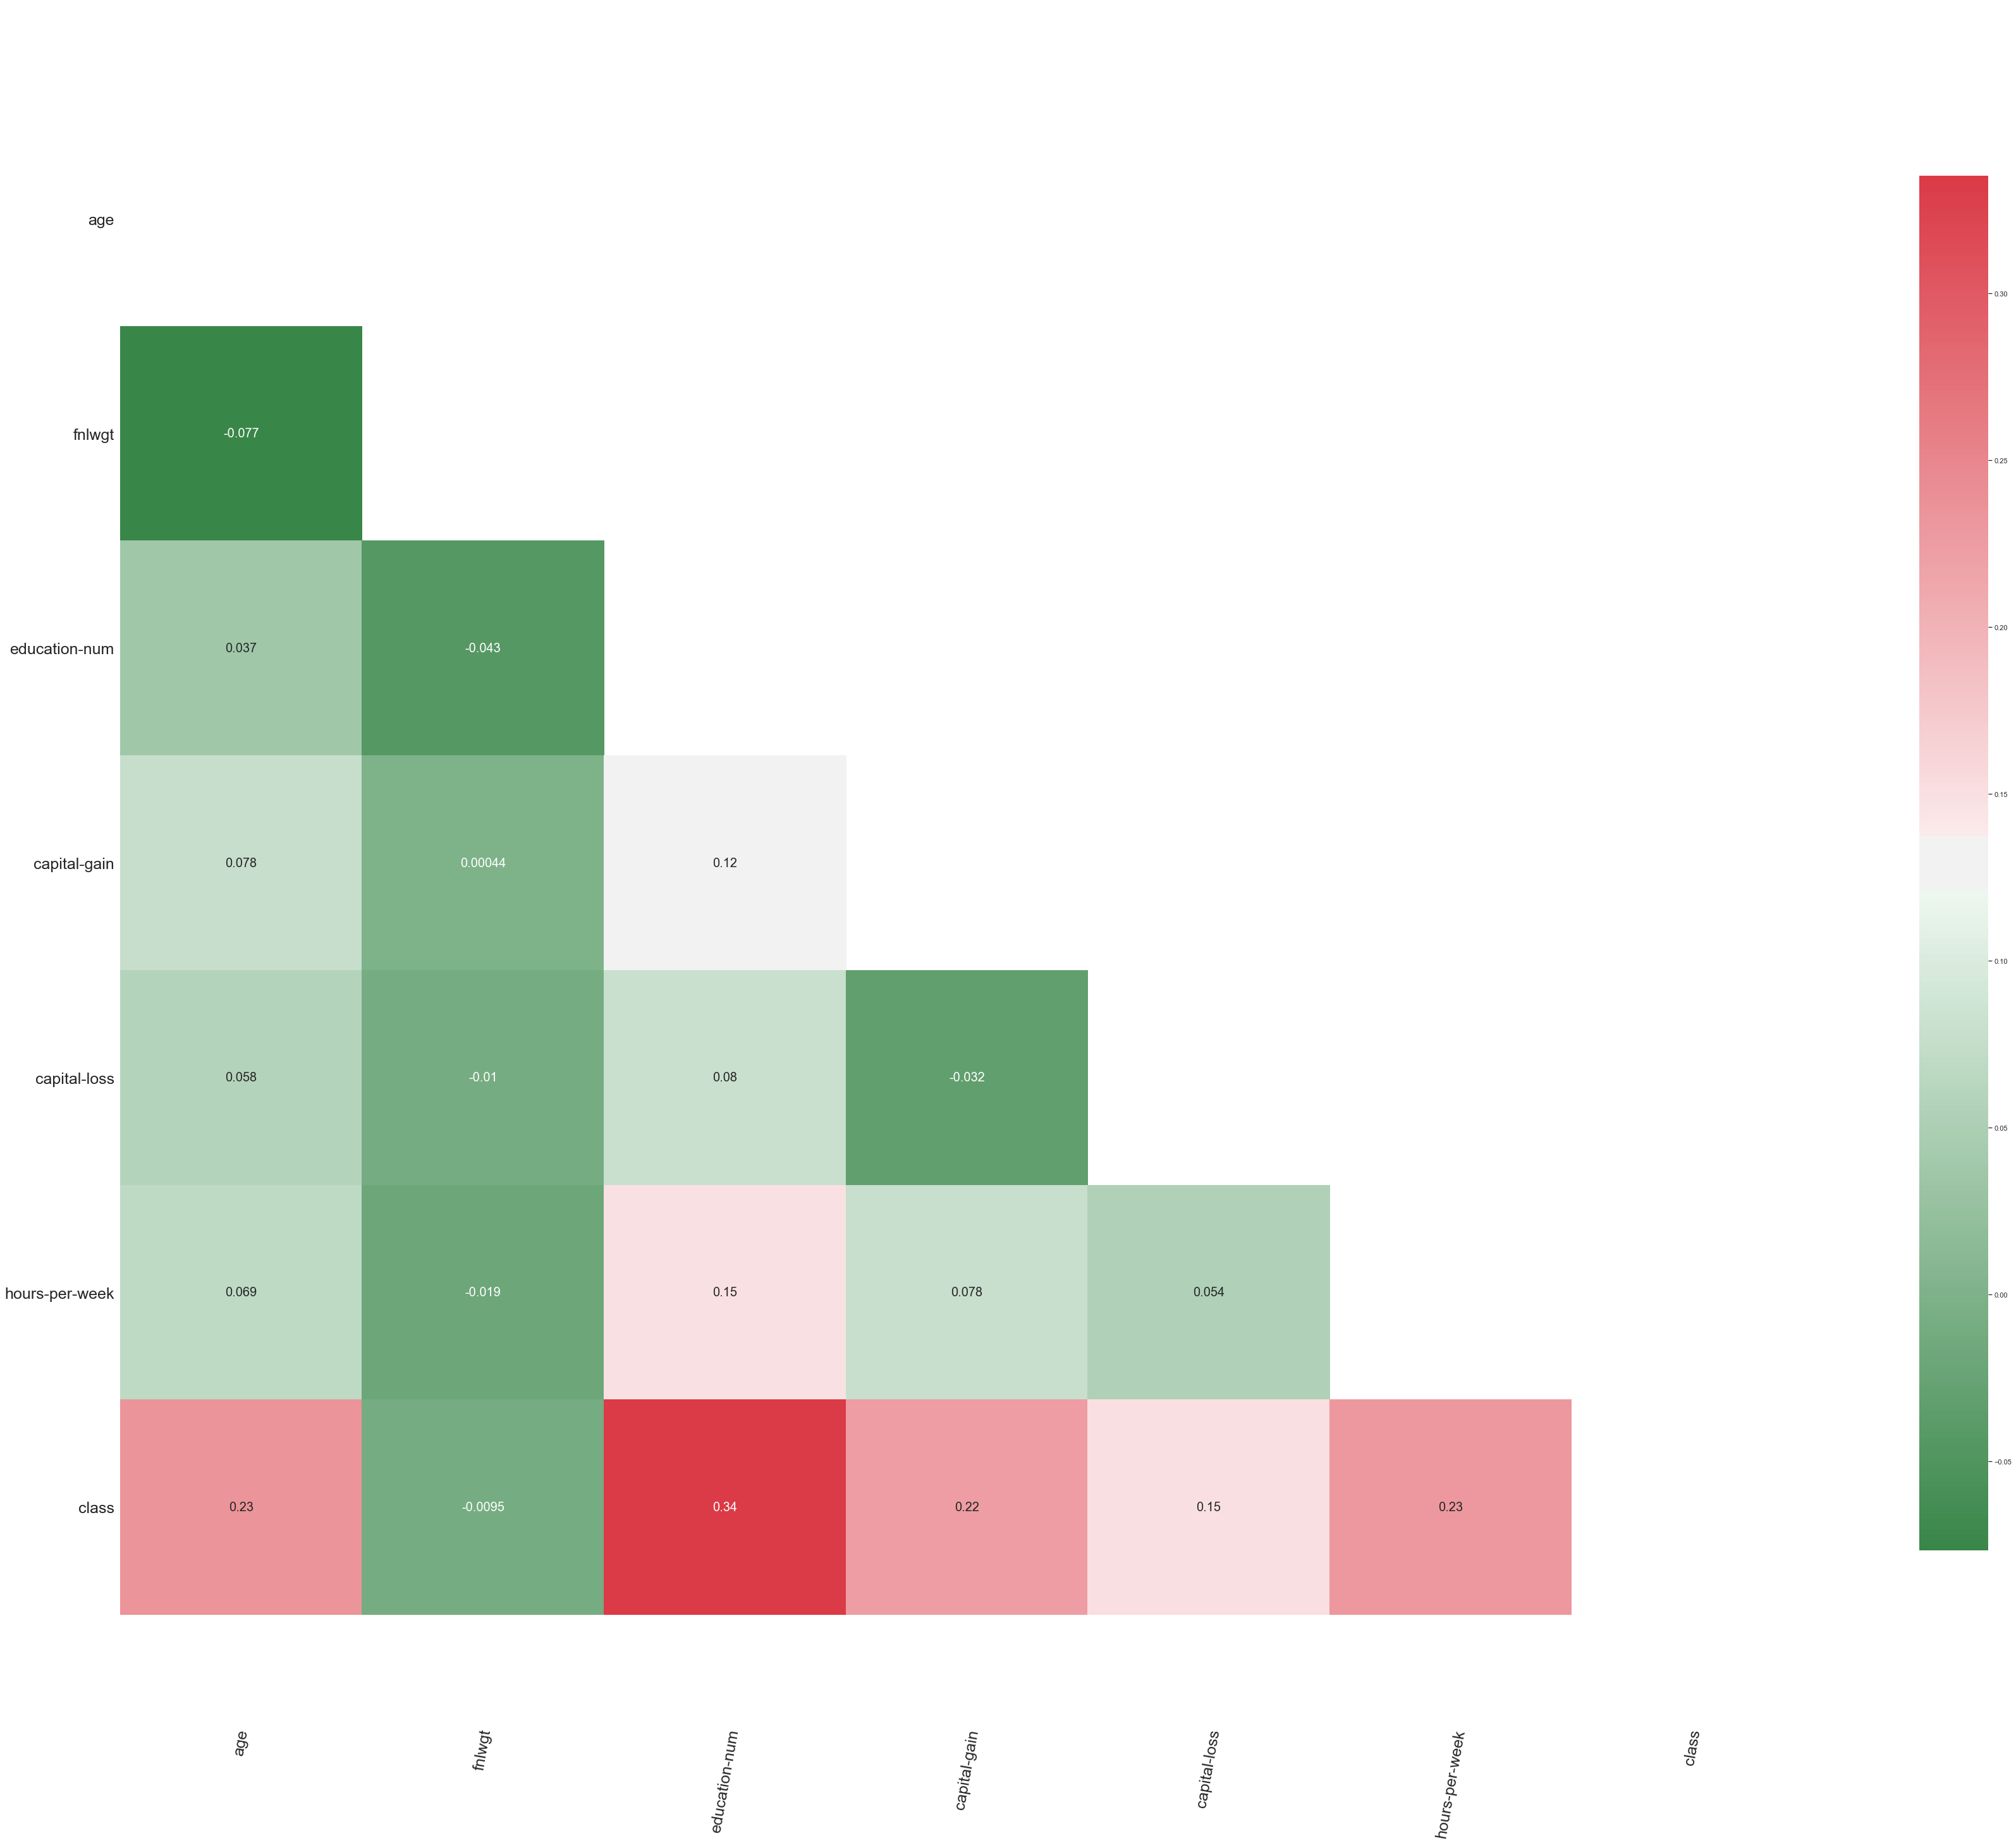

In [40]:
sns.set(style="white")
# Creating the data
data = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(60,50))


# Create a custom color palette
cmap = sns.diverging_palette(133, 10,
                      as_cmap=True)  
# Plot heatmap
g = sns.heatmap(data=data, annot=True, cmap=cmap, ax=ax, 
                mask=mask, 
                annot_kws={"size":20},  
               cbar_kws={"shrink": 0.8} 
               );

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Changes size of the values on the label
ax.tick_params(labelsize=25) 
ax.set_yticklabels(g.get_yticklabels(), rotation=0);
ax.set_xticklabels(g.get_xticklabels(), rotation=80);
plt.savefig('correlation_heatmap.png', transparent = True)

In [27]:
df_default_corrs = data.iloc[:-1,-1:]   # data = df.corr()  REMEMBER!! HAHAHAHAHAHA
df_default_corrs

,class
age,0.234039
fnlwgt,-0.009481
education-num,0.335182
capital-gain,0.223333
capital-loss,0.150523
hours-per-week,0.229690


<AxesSubplot:>

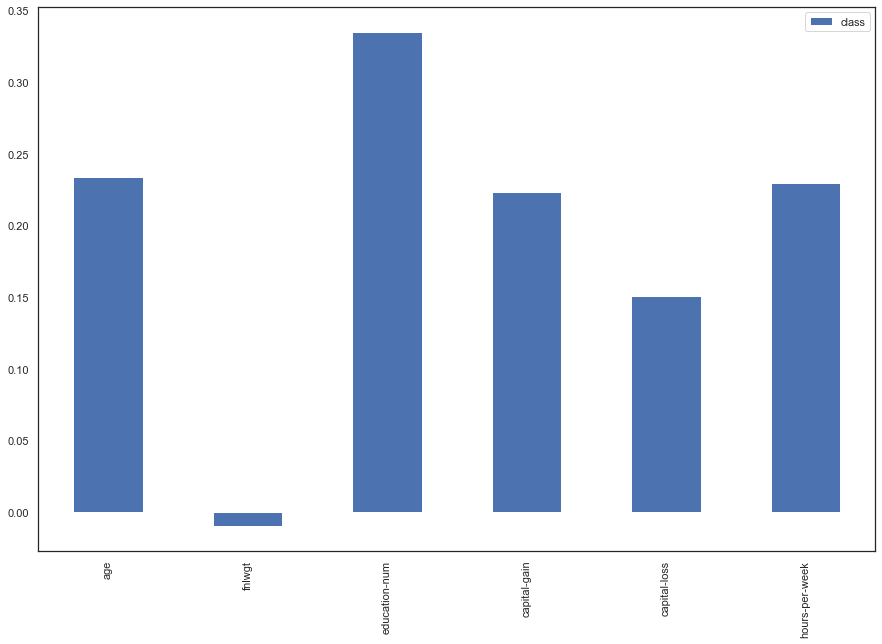

In [28]:
df_default_corrs.plot(kind='bar',figsize=(15,10))

From the graph above we can visually see that PAY_1 has the highest correlation to DEFAULT or not!

In [29]:
data.iloc[:-1,-1:].max()  # This refers to PAY_1

class    0.335182
dtype: float64

## Feature Importance Described by RandomForest

In [30]:
# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]

# Data splitting for 80% Train/Val and 20% Test 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=69) # 20% holdout 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state=69) # Train/Val

# Initializing the scaler  (Just scale every single time lol)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train_val.values)

## Scale the Predictors on the train/val dataset
X_train_val_scaled = std.transform(X_train_val.values) 

## This line instantiates the model. 
rf = RandomForestClassifier() 

## Fit the model on your training data.
rf.fit(X_train_val_scaled, y_train_val) 

# Obtain the feature importance
feature_importance = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['Variable_Importance']).sort_values('Variable_Importance',ascending=True)

# Set seaborn contexts 
sns.set(style="whitegrid")

feature_importance.plot.barh(figsize=(15,10))

ValueError: could not convert string to float: ' Private'